In [2]:
import os
from glob import glob
import copy

import numpy as np
import pandas as pd
import xarray as xr
from collections import defaultdict

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from smrt import make_model, make_snowpack, sensor_list, make_ice_column, make_interface
from smrt.core.sensor import SensorList

from smrt.emmodel.symsce_torquato21 import derived_SymSCETK21
from smrt.permittivity.snow_mixing_formula import wetsnow_permittivity_memls

from esa_4d_antarctica.modeling import GoodSnowpacks, depth, frequency_colors, total_liquid_water, prepare_wet_snowpacks, prepare_saturated_snowpacks

runner=None

Text(0.5, 0, 'Density (kg m$^{-3}$)')

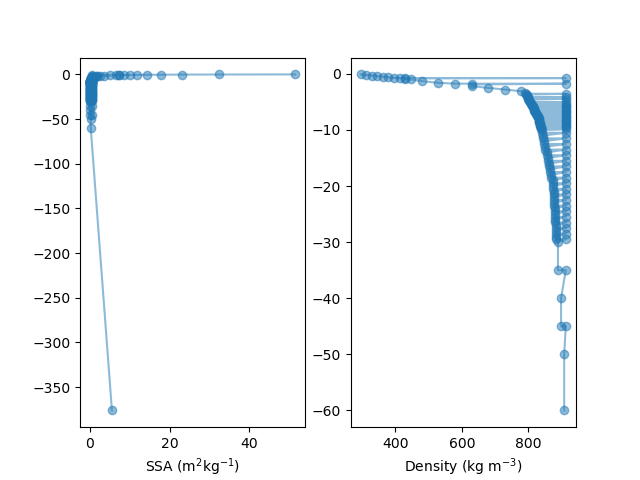

In [3]:
location = "aws19"
season = "winter"
site = GoodSnowpacks(location, season, version=31)

f, axs = plt.subplots(1, 2)
z = -np.array(depth)

best_params = site.best_params
# best 
sp = site.prepare_best_snowpack()
axs[0].plot([l.microstructure.compute_ssa() for l in sp.layers], -sp.layer_depths, '-o', alpha=0.5)

axs[1].plot(sp.layer_densities[:-1], -sp.layer_depths[:-1], '-o', alpha=0.5)

axs[0].set_xlabel("SSA (m$^2$kg$^{-1}$)")
axs[1].set_xlabel("Density (kg m$^{-3}$)")

# Experiment 1: Sensitivity to TWC in a given snowpack. Wet snow layer 10cm thick. 

In [5]:
filename = f"LWCSensitivityData-Original/results-ensemble-experiment1.csv"

twc = list(np.linspace(0.0, 1, 10, endpoint=False)) + \
            list(np.linspace(1, 5, 10, endpoint=False)) + \
            list(np.linspace(5, 20, 10))

freqs = ['06', '10', '19', '37']
channels = [freq + pol for freq in freqs for pol in 'HV']
radiometer = sensor_list.amsre(channels)

m = make_model(derived_SymSCETK21(wetsnow_permittivity_memls),
               "odort", rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan'))

if not os.path.exists(filename):
    
    drysps, weights = site.prepare_good_snowpacks(size=1000, as_dataframe=False, season_temperature=273)
    print("len=", len(drysps))

    #radar = [sensor_list.quikscat(), sensor_list.ascat(theta=40)]

    snowpacks = [prepare_wet_snowpacks(drysp, 0.0, 0.10, total_liquid_water=twc_) for drysp in drysps for twc_ in twc]

    #lwc = list(map(total_liquid_water, snowpacks))
    #f_liquid = [sp.layers[0].liquid_water for sp in snowpacks]
    #assert np.allclose(lwc, twc)
    print('run')

    presult = m.run(radiometer, list(snowpacks), parallel_computation=True, runner=runner)

    #aresult_xr = [m.run(ra, list(snowpacks), snowpack_dimension=('twc', twc), parallel_computation=True, runner=runner) for ra in radar]

    presult_save = presult
    presult = presult.to_dataframe()  #.Tb_as_dataframe(channel_axis='column')

    presult['twc'] = np.tile(twc, len(drysps))
    presult['sp'] = np.repeat(range(len(drysps)), len(twc))
    presult['weights'] = np.repeat(weights, len(twc))
    #aresult = [res.sigma_dB_as_dataframe(channel_axis='column') for res in aresult_xr]

    presult.to_csv(filename)
else:
    presult = pd.read_csv(filename)

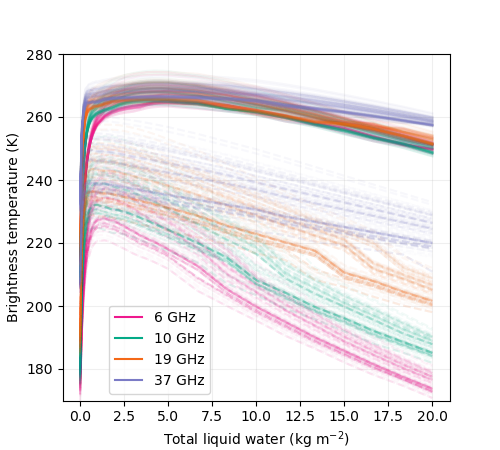

In [6]:
f, axs = plt.subplots(1, 1, sharex=True, figsize=(5, 4.5))
axs = [axs]

for ch in freqs:
    
    for i, gpresult in presult.groupby('sp'):
        alpha = 15 * gpresult.weights.mean() / len(presult)
        alpha = min(alpha, 1)
        label = f'{int(ch)} GHz' if i == 0 else None
        axs[0].plot(twc, gpresult[ch + 'V'], color=frequency_colors[ch], label=label, alpha=alpha)
        axs[0].plot(twc, gpresult[ch + 'H'], '--', color=frequency_colors[ch], alpha=alpha)
        #axs[0].plot(twc, gpresult[ch + 'H'] / gpresult[ch + 'V'], '--', color=frequency_colors[ch], alpha=alpha)
    
#axs[1].plot(twc, aresult[0]['HH46'], '-', label='Quikscat HH')
#axs[1].plot(twc, aresult[0]['VV54'], '-', label='Quikscat VV')
#axs[1].plot(twc, aresult[1]['VV40'], '-', label='ASCAT / Sentinel 1')
handles = [mlines.Line2D([], [], color=frequency_colors[ch], label= f'{int(ch)} GHz') for ch in freqs]

for i in [0]:
    axs[0].legend(handles=handles, loc='best', bbox_to_anchor=(0., 0., 0.5, 0.5))
    axs[i].set_xlabel("Total liquid water (kg m$^{-2}$)")
axs[0].set_ylabel("Brightness temperature (K)")

axs[0].grid(alpha=0.2)
axs[0].set_ylim((170, 280))


#plt.xlim((0, 2))

plt.savefig(f"fig-{location}-{season}-ensemble-experiment1.pdf")

In [7]:
gr = presult['twc']    
mean = presult[channels].multiply(presult["weights"], axis="index").groupby(gr).sum().divide(presult["weights"].groupby(gr).sum(), axis="index")
var =  (presult[channels]**2).multiply(presult["weights"], axis="index").groupby(gr).sum().divide(presult["weights"].groupby(gr).sum(), axis="index")
std = np.sqrt((var - mean**2))

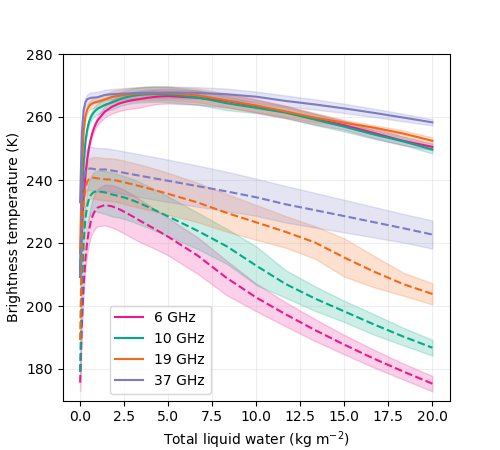

In [8]:
f, axs = plt.subplots(1, 1, sharex=True, figsize=(5, 4.5))
axs = [axs]

for ch in freqs:
    
    label = f'{int(ch)} GHz' if i == 0 else None
    
    axs[0].fill_between(twc, (mean - std)[ch + 'V'], (mean + std)[ch + 'V'], color=frequency_colors[ch], label=label, alpha=0.2)
    axs[0].fill_between(twc, (mean - std)[ch + 'H'], (mean + std)[ch + 'H'], color=frequency_colors[ch], label=label, alpha=0.2)
    
    axs[0].plot(twc, mean[ch + 'V'], color=frequency_colors[ch], label=label)
    axs[0].plot(twc, mean[ch + 'H'], '--', color=frequency_colors[ch])
        
        
    
        
        #axs[0].plot(twc, gpresult[ch + 'H'] / gpresult[ch + 'V'], '--', color=frequency_colors[ch], alpha=alpha)
    
#axs[1].plot(twc, aresult[0]['HH46'], '-', label='Quikscat HH')
#axs[1].plot(twc, aresult[0]['VV54'], '-', label='Quikscat VV')
#axs[1].plot(twc, aresult[1]['VV40'], '-', label='ASCAT / Sentinel 1')
handles = [mlines.Line2D([], [], color=frequency_colors[ch], label= f'{int(ch)} GHz') for ch in freqs]

for i in [0]:
    axs[0].legend(handles=handles, loc='best', bbox_to_anchor=(0., 0., 0.4, 0.5))
    axs[i].set_xlabel("Total liquid water (kg m$^{-2}$)")
axs[0].set_ylabel("Brightness temperature (K)")

axs[0].grid(alpha=0.2)
axs[0].set_ylim((170, 280))


#plt.xlim((0, 2))

plt.savefig(f"fig-{location}-{season}-ensemble-experiment1.pdf")
